# Getting Started With `fab`

This document will serve as a basic tutorial for working with `fab` to analyze the Flesh and Blood trading card game. In it we'll go over how to load card data, manipulate and filter lists of cards, compute useful statistics, build and analyze card decks, and graphically analyze cards with `plotly`. Note that we'll be adding type annotations to variables for educational purposes, but they aren't necessary.

## Importing Card Data

The first thing we'll want to do is import card data from a `.json` or `.csv` source (ideally `.json`). We'll make use of the `CardList` and `CardSetCollection` objects to do this.

In [1]:
from fab import Card, CardList, CardSetCollection

# We'll use this variable to represent every card in the game. Note that we
# also specify `set_catalog=True`, which essentially tells `fab` to treat this
# as such.
cards: CardList = CardList.load('~/work/data/cards.json', set_catalog=True)

# Similarly, this variable represents every card set in the game (such as
# "Monarch").
card_sets: CardSetCollection = CardSetCollection.load('~/work/data/card-sets.json', set_catalog=True)

## Working With `Card` Objects

Let's focus on working with a single card for a moment. Here we'll just pick the 50th card in the list of all cards. Below you can see that `CardList` objects may be accessed like any other Python list.

In [2]:
card50: Card = cards[50]

We can see what this card looks like with the `.image()` method.

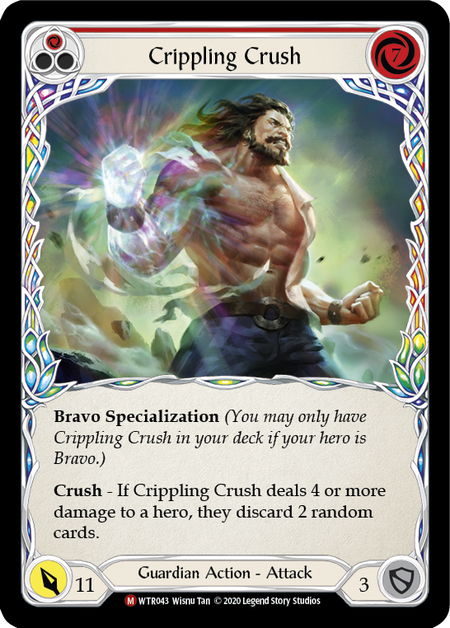

In [3]:
card50.image()

Now looking at the image above, compare the data physically printed on the card and how its represented in `fab` below:

In [4]:
card50

Card(body='**Bravo Specialization** *(You may only have Crippling Crush in your deck if your hero is Bravo.)*\n\n**Crush** - If Crippling Crush deals 4 or more damage to a hero, they discard 2 random cards.', cost=7, defense=3, flavor_text=None, full_name='Crippling Crush (1)', grants=[], health=None, identifiers=['1HP050', 'WTR043'], image_urls={'1HP050 - N': 'https://storage.googleapis.com/fabmaster/media/images/1HP050.width-450.png', 'WTR043 - A': 'https://storage.googleapis.com/fabmaster/media/images/WTR_43.width-450.png', 'WTR043 - U': 'https://storage.googleapis.com/fabmaster/media/images/U-WTR43.width-450.png'}, intelligence=None, keywords=['Bravo Specialization', 'Crush'], name='Crippling Crush', pitch=1, power=11, rarities=['M', 'M'], sets=['1HP', 'WTR'], tags=[], type_text='Guardian Action - Attack', types=['Guardian', 'Action', 'Attack'])

The above representation should (hopefully) be pretty clear: `body` represents the full body text of the card, `power` is the value next to the spear icon, `types` just contains the individual words within `type_text`, and so on.

In addition to obtaining an official card image for the card, we can render a Markdown version:

In [5]:
card50.render()

### Crippling Crush _(Guardian Action - Attack)_

**Bravo Specialization** *(You may only have Crippling Crush in your deck if your hero is Bravo.)*

**Crush** - If Crippling Crush deals 4 or more damage to a hero, they discard 2 random cards.

| Attribute | Value |
|---|---|
| Attack Power | 11 |
| Defense | 3 |
| Pitch Value | 1 |
| Resource Cost | 7 |


</br>

We can also ask some convenience questions about the card:

In [6]:
[card50.is_attack(), card50.is_defense_reaction()]

[True, False]

With regard to instantiating cards, we often know the full name of a card we might want to work with. Since we specified `set_catalog=True` when calling `CardList.load()`, we have the ability to create `Card` objects from their `full_name` (the name of the card and its pitch value, if applicable):

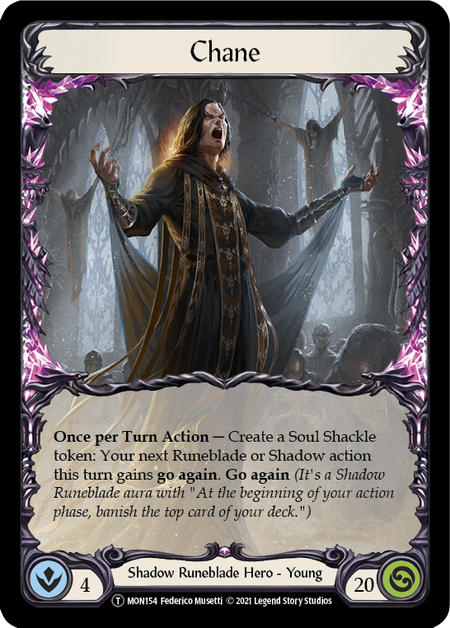

In [7]:
Card.from_full_name('Chane').image()

Note that we needed to `import` the `Card` object.

## Working With `CardList` Objects

Now that we know how to work with cards, let's return to `CardList` objects. Again these are basically a wrapper around type `list[Card]`, so pretty much anything you can do with lists in Python, you can do with `CardList` objects, so we won't go into detail about how to iterate over them, etc. Instead let's focus on filtering, grouping, and sorting cards and then dive into some statistics we can compute on card lists.

### Filtering Cards

Since we've defind `cards` to represent every card in the game, we'd like to narrow down a smaller group of cards we'd like to work with given our goal. From this point onward, let's assume our goal is to build a Chane deck. Since Chane is a _Shadow Runeblade_ hero, we know that our deck can only contain _Generic_, _Shadow_, or _Runeblade_ cards. We can use the `.filter()` method to accomplish this.

In [8]:
# .filter() provides a variety of ways to filter cards. By specifying a list
# of strings to the `types` argument, we are saying that we'd like the subset
# of cards that have any of the specified types in their `types` field.
compatible: CardList = cards.filter(types=['Generic', 'Shadow', 'Runeblade'])

# Just to check ourselves, let's peek at a card just to make sure.
compatible[42].type_text

'Generic Action - Attack'

A deck in Flesh and Blood really consists of two parts: the deck that you "draw" from (what this library likes to call the "main" deck) and the set of cards that make up your hero, their weapon(s) and equipment, and any tokens your hero uses. When filtering this kind of stuff, `CardList` provides a few handy methods that get the job done without having to craft a `.filter()` invocation.

In [9]:
# Equipment cards (excluding "Items")
equipment: CardList = compatible.equipment()

# Tokens
tokens: CardList = compatible.tokens()

# Weapons
weapons: CardList = compatible.weapons()

# "Main" deck stuff. Note that it's easiest to filter out everything that isn't
# equpment, a weapon, a token, or a hero.
main_deck: CardList = compatible.filter(types=['Equipment', 'Token', 'Weapon', 'Hero'], negate=True)

# Just to test, let's get a sample from each group.
[equipment[0].full_name, tokens[0].full_name, weapons[0].full_name, main_deck[0].full_name]

['Spell Fray Cloak', 'Quicken', 'Nebula Blade', 'Go Bananas (2)']

Let's clean some stuff up here. We know that while _Quicken_ is technically a valid token to have in a Chane deck, we probably really only care about _Soul Shackle_. So let's remove every token except _Soul Shackle_ and remove cards the reference any of the other tokens.

In [10]:
# Pull out all of the unused token names and strip them from `tokens`.
unused_tokens: list[str] = tokens.filter(name='Soul Shackle', negate=True).names()
tokens: CardList = tokens.filter(name='Soul Shackle')

# Remove any cards from the main deck that reference an unused token. Note that
# we have to handle the case where `body` is `None`, which we can do by just
# typecasting it to `str` beforehand.
main_deck: CardList = main_deck.filter(body=lambda body: not any(token in str(body) for token in unused_tokens))

# Here's what we removed
unused_tokens

['Blasmophet, the Soul Harvester',
 'Copper',
 'Quicken',
 'Runechant',
 'Silver',
 'Ursur, the Soul Reaper']

Notice that the `.filter()` method allows us to specify a `lambda` for any card field. Pretty nifty. Next, we'll move on to grouping and then sorting card lists.

### Grouping Cards

Now that we've filtered our cards into smaller "sub-decks", we can use the `.group()` method to further break down these card lists. The `.group()` method produces a dictionary of type `dict[Any, CardList]` where the key type depends on the value of the `by` argument passed to the method. Let's first suppose that we'd like to organize our `equipment` list by the type of equipment (head, legs, etc). From there we could inspect each sub-list for equipment for neat effects.

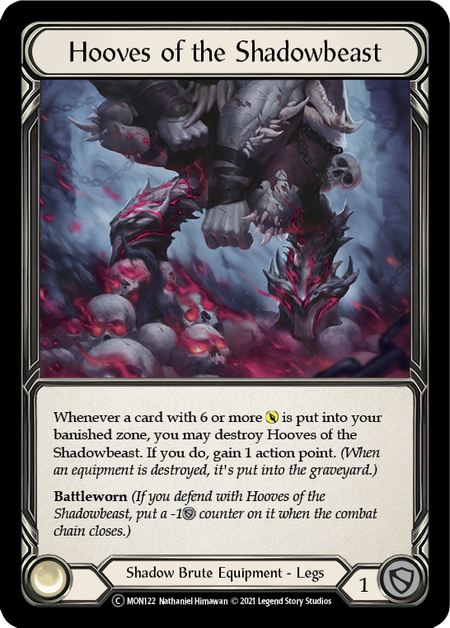

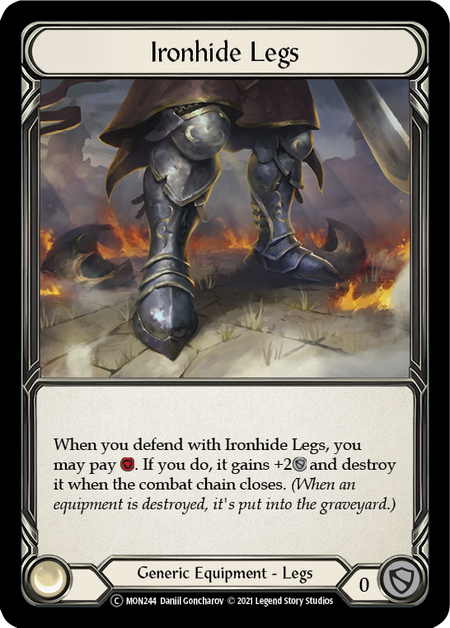

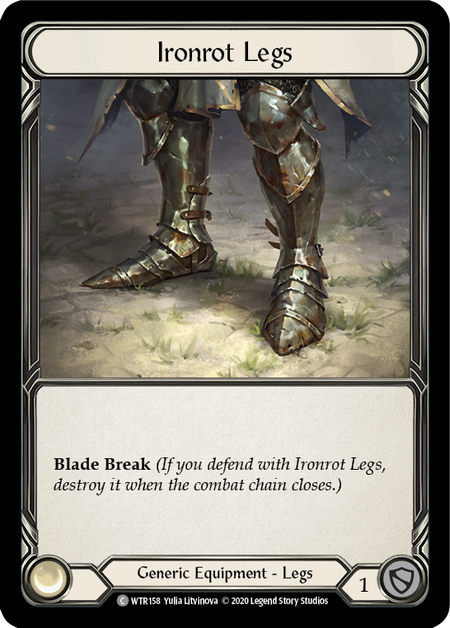

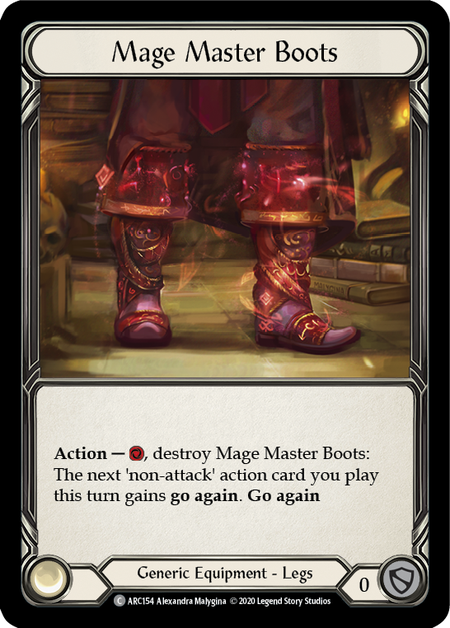

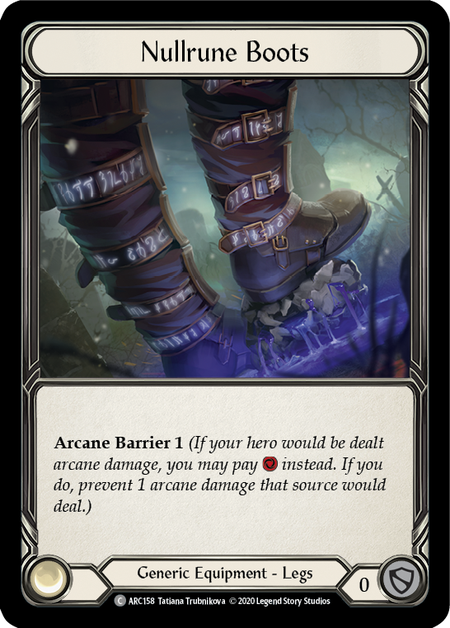

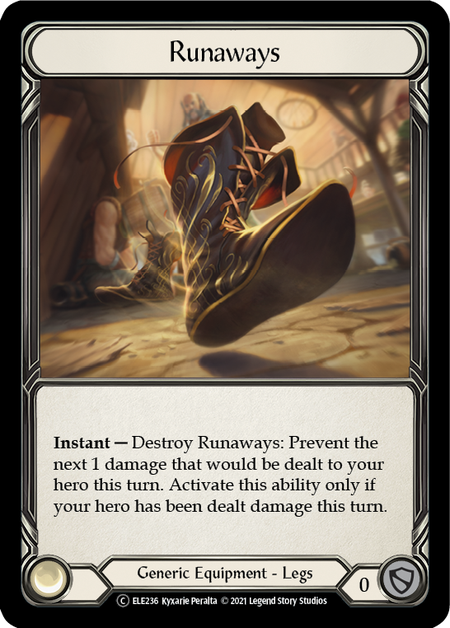

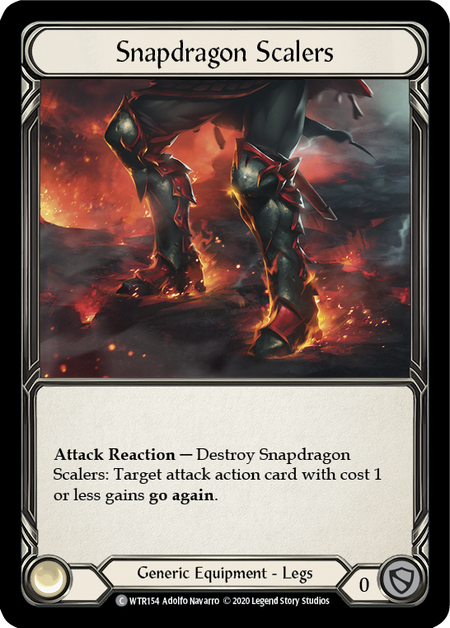

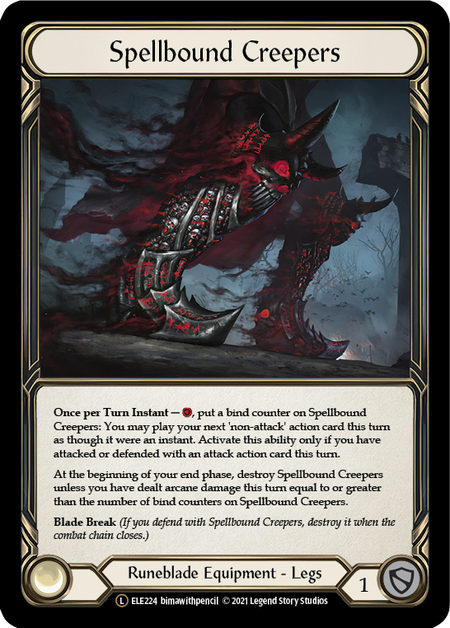

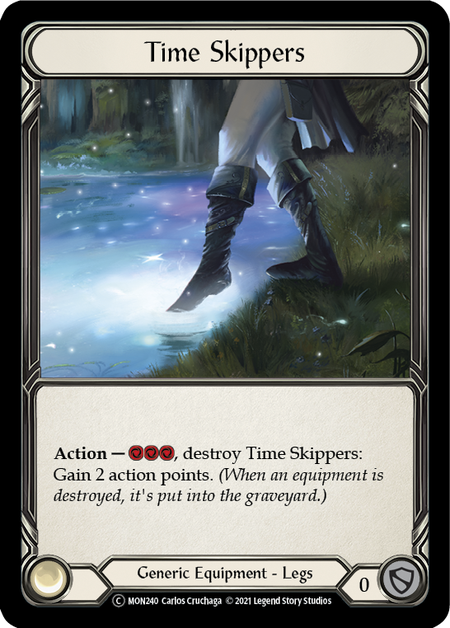

In [11]:
# When we first run `.group(by='type')` we include all card types as keys, but
# we only care about the `Head`, `Chest`, `Arms`, and `Legs` types, so we can
# just use dictionary comprehension to filter those out.
egroups: dict[str, CardList] = equipment.group(by='type')
egroups: dict[str, CardList] = {t: egroups[t] for t in ['Head', 'Chest', 'Arms', 'Legs']}

# Let's grab card images for every leg piece:
[card.image() for card in egroups['Legs']];

#### Quick Note About Filtering 

Wait a minute, what is _Hooves of the Shadowbeast_ doing in there? Notice that it's a _Shadow **Brute** Equipment_, and therefore not actually compatible with our deck. I admit I was a little cheeky by moving on from the _Filtering Cards_ section and ignoring a slight flaw in our logic. See, when we filtered via

```python
cards.filter(types=['Generic', 'Shadow', 'Runeblade'])
```

we're saying we'd like to include cards that have `Generic` _or_ `Shadow` _or_ `Runeblade` in their `types` field. Unfortunately, this is where the Flesh and Blood TCG itself actually steps on our toes a bit. You see, according to the [FaB Comprehensive Rules Document](https://storage.googleapis.com/fabmaster/media/documents/FaB_Comprehensive_Rules_v2.0.2.pdf) under _Object Properties_ > _Type Box_:

> Type boxes are typically written in the format `[SUPERTYPES] [TYPE] [— SUBTYPES?]`, where `SUPERTYPES` is one or more supertypes, `TYPE` is a type, and `SUBTYPES` (if any) is one or more subtypes.

Note the word "typically". Indeed there are many type box texts that do not follow this structure, and thus we cannot rely on it for parsing. Luckily since we know a bit about the cards, we could re-filter out _Shadow Brute_ cards since at the time of writing this, _Brute_ is the only other class that leverages _Shadow_ cards. Let's quickly correct this:

In [12]:
equipment: CardList = equipment.filter(types='Brute', negate=True)
main_deck: CardList = main_deck.filter(types='Brute', negate=True).filter(body='Levia', negate=True)

### Sorting Cards

Since we're building out a deck, we may want to order cards in a certain way while we look through them. This is where the `.sort()` method comes in. In the example below, lets assume that we're intested in looking at cards with the highest power rating that pitch for three resources.

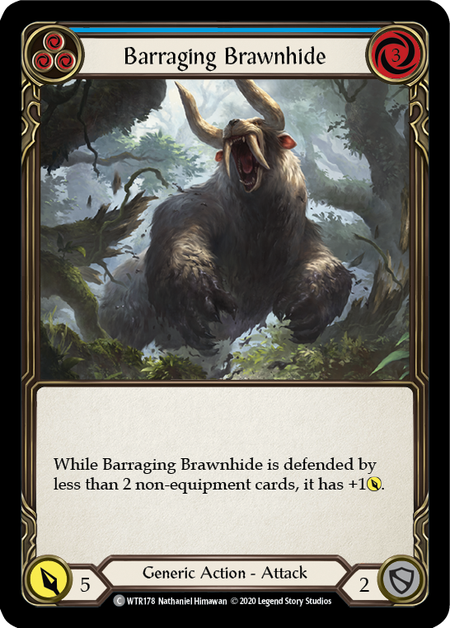

In [13]:
main_deck.filter(pitch=3).sort(key='power', reverse=True)[0].image()

### Statistical Analysis

Before we move on to `Deck` objects, we should go over the various statistical methods available to `CardList` objects. In addition to individual statistics methods such as `.mean_power()` or `.stdev_pitch()`, `CardList` objects also have an overall `.statistics()` method which returns all of the various statistics in a single dictionary of type `dict[str, float|int]`. Let's compute the statistics of our possible main deck cards:

In [14]:
main_deck.statistics()

{'count': 349,
 'max_cost': 6,
 'max_defense': 7,
 'max_health': 0,
 'max_intelligence': 0,
 'max_pitch': 3,
 'max_power': 7,
 'mean_cost': 1.07,
 'mean_defense': 2.41,
 'mean_health': 0.0,
 'mean_intelligence': 0.0,
 'mean_pitch': 2.07,
 'mean_power': 3.59,
 'median_cost': 1,
 'median_defense': 2.0,
 'median_health': 0.0,
 'median_intelligence': 0.0,
 'median_pitch': 2,
 'median_power': 4.0,
 'min_cost': 0,
 'min_defense': 1,
 'min_health': 0,
 'min_intelligence': 0,
 'min_pitch': 1,
 'min_power': 0,
 'pitch_cost_difference': 351,
 'power_defense_difference': -22,
 'stdev_cost': 1.06,
 'stdev_defense': 0.67,
 'stdev_health': 0.0,
 'stdev_intelligence': 0.0,
 'stdev_pitch': 0.83,
 'stdev_power': 1.5,
 'total_cost': 366,
 'total_defense': 718,
 'total_health': 0,
 'total_intelligence': 0,
 'total_pitch': 717,
 'total_power': 696}

I should note here that by default, the various statistical methods that return `float` numbers are rounded according to `round(x, 2)` and can be adjusted via a `precision` argument.

## Working with `Deck` Objects

While we started the process of building a deck with `CardList` objects, `fab` actually provides a `Deck` object that provides additional utility methods. Let's take a look: 

In [15]:
from fab import Deck
print(Deck.__doc__)


    Represents a deck of Flesh and Blood cards.

    Attributes:
      cards: The "main" part of the deck from which one draws cards.
      format: The game format associated with the deck, being `Blitz`, `Classic Constructed`, `Commoner`, or `Ultimate Pit Fight`.
      hero: The hero card associated with the deck.
      inventory: The list of weapon/equipment cards associated with the deck (not including items).
      name: An arbitrary name for the deck.
      tokens: Any token cards associated with the deck.
    


To get started in building a deck for Chane, we can simply initialize a new `Deck` object with just our hero.

In [16]:
deck: Deck = Deck(name = 'Chane Blitz Deck', hero = Card.from_full_name('Chane'))

Note that by not explicitly specifying a `format`, the `Deck` class assumes `Blitz`.

The `Deck` object provides a number of useful methods for building out a deck. For instance, we can automatically filter out cards that work with our deck:

In [17]:
relevant: CardList = deck.filter_related(cards)
len(relevant)

AttributeError: type object 'CardList' has no attribute '_Deck__hero_filter_related'

From there, one can build up a deck by filtering through `relevant` and overriding the appropriate fields. We'll just re-use the `CardList` objects we filtered above.

In [ ]:
deck.cards = main_deck[0:40] # grab the first 40 cards
deck.inventory = equipment + weapons
deck.tokens = tokens

Once we've got our deck built, we can validate its legality with the `.is_valid()` method. This method returns a tuple response of the form: `(<answer>, <reason>)`.

In [ ]:
deck.is_valid()

As we can see, the `.is_valid()` method reminded us that we forgot to limit the number of cards in our inventory deck, so let's correct that and try again.

In [ ]:
deck.inventory = (equipment + weapons)[0:11]
deck.is_valid()

Just like `CardList` objects, `Deck` objects may be serialized to/from `.json` files. In addition, they may also generate (or be generated from) decklists. Decklists in `fab` are dictionaries of type`dict[str, int]` where the key corresponds to the `full_name` of a card, and the value is the number of copies of the card present in the deck. Let's generate a decklist for our example deck below. Note that our decklist will look pretty silly, since we're only including one copy of each card.

In [ ]:
deck.to_deck_list(include_tokens=True)

The last thing to mention about `Deck` objects is the ability to compute overall statistics. The `Deck.statistics()` method automatically calls the `CardList.statistics()` method on all of the underlying "components" of your deck:

In [ ]:
deck.statistics()

## Graphical Analysis

This section is still WIP while the graphics library is being worked on.